# <ins> TRANSFORMS

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import monai
import monai.transforms as transforms
from digipath.plotter import plotter
from tqdm import tqdm
import torch
from sklearn.model_selection import train_test_split

/home/gpievanitrapletti/.conda/envs/gym/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load data
train_data = np.load('data/tiles/train_data.npz')

In [3]:
# Change channels position, as required by Monai transforms, while turning to grayscale (np.mean())
tiles = np.concatenate([np.mean(x, axis=-1, keepdims=True).transpose(2, 0, 1)[np.newaxis, ...] for x in train_data['images']])[:100]
gts = np.concatenate([x[np.newaxis, np.newaxis, ...] for x in train_data['masks']])[:100]

print((tiles.shape))
print((gts.shape))

(100, 1, 64, 64)
(100, 1, 64, 64)


## GEOMETRIC TRANSFORMS

- transforms.RandRotated(keys=['image', 'mask'], range_x=[0, 180], prob=0.9)
- transforms.RandAxisFlipD(keys=['image', 'mask'], prob=0.9)
- transforms.Rand2DElasticD(keys=['image', 'mask'], spacing=(10), magnitude_range=(2, 5), prob=0.9)

- transforms.RandAdjustContrastd(keys=['image'], prob=0.99)

In [4]:
# # Transforms
# mytransform = monai.transforms.Compose([
#     transforms.RandRotated(keys=['image', 'mask'], range_x=[0, 180], prob=0.9),
#     transforms.RandAxisFlipD(keys=['image', 'mask'], prob=0.9),
#     # transforms.Rand2DElasticD(keys=['image', 'mask'], spacing=(10), magnitude_range=(2, 5), prob=0.9)
# ])

In [5]:
mytransform = monai.transforms.Compose([
   transforms.RandAffineD(keys=['image', 'mask'], shear_range=(1.0, 2.0), prob=0.9)
])

In [6]:
# Dataset as dict, as required by the transforms 
# (to apply transforms in the same way for both the image and the mask)
datadict = [{'image': tiles[i].copy(), 'mask': gts[i].copy()} for i in range(len(tiles))]

# datadict = [{'image': tiles_t[i], 'mask': gts_t[i]} for i in range(len(tiles_t))]

In [7]:
# Dataset
dataset = monai.data.Dataset(data=datadict, transform=mytransform)

In [8]:
# Get data transformed (needed to apply the same transform to the image and its mask)
data = [dataset[i] for i in tqdm(range(len(dataset)))]

# # DO NOT DO THIS!
# tile_transformed = dataset[0]['image']
# mask_transformed = dataset[0]['mask']
# # In this way dataset[0] is created two separate times, thus resulting in 
# # different transforms (ex. tile rotate to the righr while mask rotate to the left)

100%|██████████| 100/100 [00:00<00:00, 249.92it/s]


In [9]:
i = 0

(64, 64, 1)


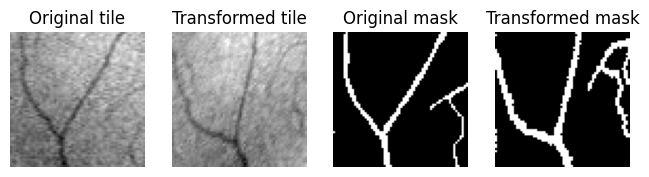

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(8, 3))

axes[0].imshow(tiles[i].transpose(1, 2, 0), cmap='gray')
axes[0].set_title('Original tile')
axes[0].axis('off')

axes[1].imshow(data[i]['image'].numpy().transpose(1, 2, 0).astype(np.uint8), cmap='gray')
axes[1].set_title('Transformed tile')
axes[1].axis('off')

axes[2].imshow(gts[i].squeeze(), cmap='gray')
axes[2].set_title('Original mask')
axes[2].axis('off')

mask = data[i]['mask'].numpy().transpose(1, 2, 0).astype(np.uint8)
mask = np.where(mask != 0, 255, 0)
print(mask.shape)                                                             ### !
axes[3].imshow(mask, cmap='gray')
axes[3].set_title('Transformed mask')
axes[3].axis('off')

plt.show()

i += 1